# Hospital Encounter Analysis by Alyssa 
Data provided by ELVTR course Data Analysis in Healthcare

## Data loading and preprocessing
Let's start with loading and checking for duplicates, and missing data. After loading, I will review the number of rows, columns, and data types.

In [37]:
#import pandas the data analysis library for python
import pandas as pd 

#upload excel file
encdf = pd.read_excel("hospital_encounter_data_10_24AC.xlsx")


print(encdf.head())

   encounter_id  admission_date origin  service_line      loc    drg  \
0  5AP7T95R6HG6           44927    ED   Internal Med  GEN MED  392.0   
1  UBE6BNHXJDV6           44927    ED   Internal Med  GEN MED  871.0   
2  2G6U4ZHPWW5V           44927    ED   Internal Med  GEN MED  871.0   
3  BSHAPPAB3YFC           44927    ED   Internal Med      PCU  871.0   
4  V6XH3DEFDTTT           44927    ED   Internal Med  GEN MED  871.0   

   discharge_date  patient_zipcode  
0           44939            65072  
1           44931            64742  
2           44929            66524  
3           44957            64150  
4           44930            64097  


In [38]:
encdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97436 entries, 0 to 97435
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   encounter_id     97436 non-null  object 
 1   admission_date   97436 non-null  int64  
 2   origin           97436 non-null  object 
 3   service_line     97436 non-null  object 
 4   loc              94512 non-null  object 
 5   drg              90616 non-null  float64
 6   discharge_date   97436 non-null  int64  
 7   patient_zipcode  97436 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 5.9+ MB


Yup that is what we expected. 
The range index indicates 97,436 entries and 8 columns (note: python index starts wih 0). Some of the data types are not quite right, I'll fix that later.

## Check for duplicates
Each row in the data set is a patient visit or encounter, and the column named 'encounter_id' is a unique identifer for the visit. Let's check this field for duplicates, we should not have any duplicates in this column.

In [39]:
#duplicate method returns boolean list, named argument keep=False will mark all dups
encdf[encdf.duplicated(subset=["encounter_id"], keep=False)]

,encounter_id,admission_date,origin,service_line,loc,drg,discharge_date,patient_zipcode
97392,DS6U23ZNFMEE,44863,OR,General Surg,NaN,621.0,44863,66023
97435,DS6U23ZNFMEE,44863,OR,General Surg,NaN,621.0,44863,66023


We caught a duplicate that appears to be identical! Let's clean this up by dropping the last row index 97435, check for duplicates, and check the number of rows. 

In [40]:
#drop method 
encdf2 = encdf.drop([97435])

print(encdf2[encdf2.duplicated(subset=["encounter_id"], keep=False)])

print("new number of rows: " + str(len(encdf2)))

Empty DataFrame
Columns: [encounter_id, admission_date, origin, service_line, loc, drg, discharge_date, patient_zipcode]
Index: []
new number of rows: 97435


## Check for missing values
The columns of "loc" and "drg" having missing values. It's best to discuss with a data owner if they have more information on why the values are missing. We will not be using these columns for our analysis, and we can ignore for now.

In [41]:
print( encdf2.isna().any() )

encounter_id       False
admission_date     False
origin             False
service_line       False
loc                 True
drg                 True
discharge_date     False
patient_zipcode    False
dtype: bool


In [42]:
print("Percentage Missing DRG Column: "+ str(round(sum(encdf2['drg'].isna())/len(encdf2['drg'])*100,2)) + "%")
print("Number missing: " + str(sum(encdf2['drg'].isna())))

Percentage Missing DRG Column: 7.0%
Number missing: 6820


With 7% missing in the DRG column, we will decide to move forward with removing these data points. If missing at random, deleting these data point should not greatly affect our analysis. 

## Calculate new measure called length of stay
#### Length of stay at the hosptial is the metric of interest, and calculated by taking the difference between the admission date and discharge date. 

#### The dates references Excel's origin date January 1, 1900 is day 1. Let's convert to the typical calendar that we use.

In [43]:
encdf2[['admission_date','discharge_date']]

,admission_date,discharge_date
0,44927,44939
1,44927,44931
2,44927,44929
3,44927,44957
4,44927,44930
...,...,...
97430,44926,44927
97431,44926,44926
97432,44926,44926
97433,44926,44926


In [44]:
encdf2['admission_date'] = pd.to_datetime(encdf2['admission_date'], unit='D', origin='1899-12-30')
encdf2['discharge_date'] = pd.to_datetime(encdf2['discharge_date'], unit='D', origin='1899-12-30')
#The offset in Excel is the number of days since 1900/01/01, with 1 being the first of January 1900,
# so add the number of days as a timedelta to 1899/12/30

In [45]:
encdf2[['admission_date','discharge_date']]

,admission_date,discharge_date
0,2023-01-01,2023-01-13
1,2023-01-01,2023-01-05
2,2023-01-01,2023-01-03
3,2023-01-01,2023-01-31
4,2023-01-01,2023-01-04
...,...,...
97430,2022-12-31,2023-01-01
97431,2022-12-31,2022-12-31
97432,2022-12-31,2022-12-31
97433,2022-12-31,2022-12-31


### Now, we calculate the length of stay. We will create a new column in the dataframe.

In [46]:
encdf2['lengthStay']=encdf2['discharge_date']-encdf2['admission_date']
encdf2['lengthStay']=encdf2['lengthStay'].dt.days
#type(encdf2['lengthStay'])
encdf2['lengthStay']

0        12
1         4
2         2
3        30
4         3
         ..
97430     1
97431     0
97432     0
97433     0
97434     0
Name: lengthStay, Length: 97435, dtype: int64

#### The time scales of month, and year are meaningful for us. I'll create two new columns to use for graphs and calculations.

In [47]:
encdf2['monthAdm'] = encdf2['admission_date'].dt.month
encdf2['yearAdm'] = encdf2['admission_date'].dt.year

encdf2[['admission_date','monthAdm','yearAdm']]

# dt Accessor object for datetimelike properties

,admission_date,monthAdm,yearAdm
0,2023-01-01,1,2023
1,2023-01-01,1,2023
2,2023-01-01,1,2023
3,2023-01-01,1,2023
4,2023-01-01,1,2023
...,...,...,...
97430,2022-12-31,12,2022
97431,2022-12-31,12,2022
97432,2022-12-31,12,2022
97433,2022-12-31,12,2022


## Exploratory Analysis

#### Based on the below histogram, length of stay is typically 0 or patients leave on the same day. 

<AxesSubplot:>

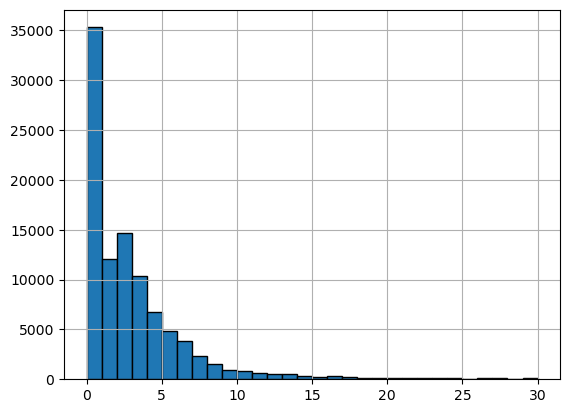

In [48]:
encdf2['lengthStay'].hist(bins=30, edgecolor='black')

####  The vairation here could be explained by service line. We can see from the historgram below with the length of stay by service line that ortho is different.

In [49]:
print("Service Lines:" + str(encdf2['service_line'].unique()))
print(" Number of lines: " + str(len(encdf2['service_line'].unique())))

Service Lines:['Internal Med' 'OB Gyn' 'Ortho' 'General Surg']
 Number of lines: 4


array([[<AxesSubplot:title={'center':'General Surg'}>,
        <AxesSubplot:title={'center':'Internal Med'}>],
       [<AxesSubplot:title={'center':'OB Gyn'}>,
        <AxesSubplot:title={'center':'Ortho'}>]], dtype=object)

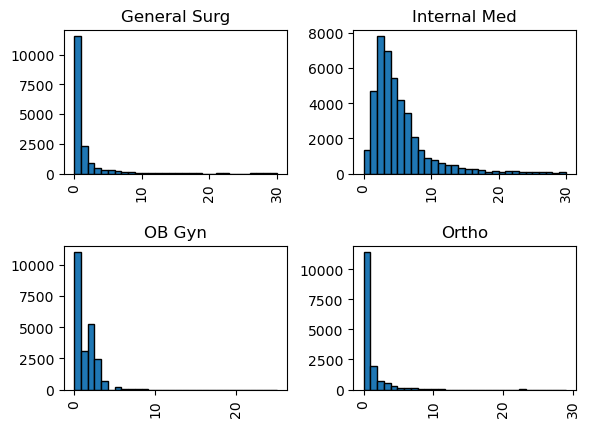

In [50]:
encdf2.hist(column=['lengthStay'], by=["service_line"], bins=30, edgecolor='black')

<p> By service line, it appears that internal medicne has a different peak and spread in their distribution of length of stay. Let's stack these distributions in one graph for another visual. </p>

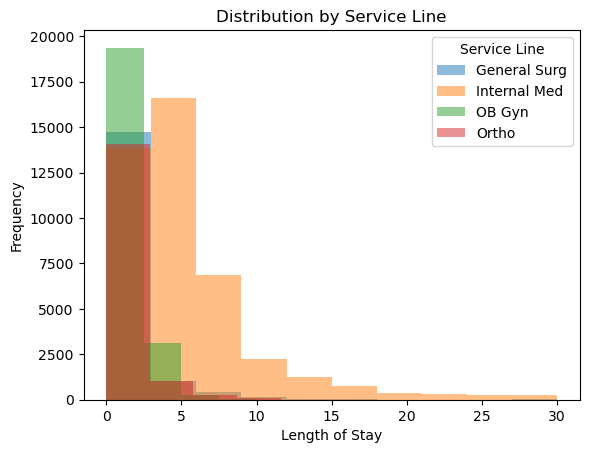

In [51]:
import matplotlib.pyplot as plt

#define points values by group
A = encdf2.loc[encdf2['service_line'] == 'General Surg', 'lengthStay']
B = encdf2.loc[encdf2['service_line'] == 'Internal Med', 'lengthStay']
C = encdf2.loc[encdf2['service_line'] == 'OB Gyn', 'lengthStay']
D = encdf2.loc[encdf2['service_line'] == 'Ortho', 'lengthStay']


#add three histograms to one plot
plt.hist(A, alpha=0.5, label='General Surg')
plt.hist(B, alpha=0.5, label='Internal Med')
plt.hist(C, alpha=0.5, label='OB Gyn')
plt.hist(D, alpha=0.5, label='Ortho')

#add plot title and axis labels
plt.title('Distribution by Service Line')
plt.xlabel('Length of Stay')
plt.ylabel('Frequency')

#add legend
plt.legend(title='Service Line')

#display plot
plt.show()


<p>Internal Medicine seems to have a shifted histogram compared to the service lines.</p>

## Merge with DRG table


In [52]:
drg = pd.read_excel("hospital_encounter_data_10_24AC.xlsx", sheet_name=1)
print(drg.head())

   MS_DRG_NUM                                       MS-DRG Title  MDC  \
0           1  HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SY...  PRE   
1           2  HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SY...  PRE   
2           3  ECMO OR TRACHEOSTOMY WITH MV >96 HOURS OR PRIN...  PRE   
3           4  TRACHEOSTOMY WITH MV >96 HOURS OR PRINCIPAL DI...  PRE   
4           5  LIVER TRANSPLANT WITH MCC OR INTESTINAL TRANSP...  PRE   

  mdc_name  TYPE   weight geometric_mean_los arithmetic_mean_los  
0      NaN  SURG  28.1461               29.9                39.3  
1      NaN  SURG  13.4731               12.3                14.9  
2      NaN  SURG  20.2371               24.7                33.2  
3      NaN  SURG  13.7317               24.2                29.2  
4      NaN  SURG   11.407                 15                20.6  


In [53]:
drg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   MS_DRG_NUM           767 non-null    int64 
 1   MS-DRG Title         767 non-null    object
 2   MDC                  767 non-null    object
 3   mdc_name             742 non-null    object
 4   TYPE                 767 non-null    object
 5   weight               767 non-null    object
 6   geometric_mean_los   767 non-null    object
 7   arithmetic_mean_los  767 non-null    object
dtypes: int64(1), object(7)
memory usage: 48.1+ KB


In [92]:
encdf3 = encdf2.merge(drg, left_on='drg', right_on='MS_DRG_NUM', how="left")

In [93]:
encdf3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97435 entries, 0 to 97434
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   encounter_id         97435 non-null  object        
 1   admission_date       97435 non-null  datetime64[ns]
 2   origin               97435 non-null  object        
 3   service_line         97435 non-null  object        
 4   loc                  94512 non-null  object        
 5   drg                  90615 non-null  float64       
 6   discharge_date       97435 non-null  datetime64[ns]
 7   patient_zipcode      97435 non-null  int64         
 8   lengthStay           97435 non-null  int64         
 9   monthAdm             97435 non-null  int64         
 10  yearAdm              97435 non-null  int64         
 11  MS_DRG_NUM           90615 non-null  float64       
 12  MS-DRG Title         90615 non-null  object        
 13  MDC                  90615 non-

##### !!! important note: Dropped 6820 rows due to null values in DRG column. Total number of rows: 97436-6820=90614

# Drop day stays

In [64]:
encdf3.groupby("service_line").agg({"lengthStay": "mean", "encounter_id": "size"})

,lengthStay,encounter_id
service_line,,
General Surg,0.860958,15276
Internal Med,4.850267,39764
OB Gyn,1.117292,21195
Ortho,0.642837,14380


In [81]:
encdf_noday = encdf3[encdf3["lengthStay"] != 0]
print("number of day stays: "  + str(sum(encdf3["lengthStay"] == 0)) )

number of day stays: 32790


In [82]:
encdf_noday.groupby("service_line").agg({"lengthStay": "mean", "encounter_id": "size"})

,lengthStay,encounter_id
service_line,,
General Surg,2.876640,4572
Internal Med,5.010157,38495
OB Gyn,2.160478,10961
Ortho,2.434554,3797


In [83]:
daily = encdf_noday.groupby(["admission_date","service_line"]).agg({"encounter_id": "size"})

In [86]:
daily.groupby(["service_line"]).agg({"encounter_id": "mean"})

,encounter_id
service_line,
General Surg,6.763314
Internal Med,53.763966
OB Gyn,15.308659
Ortho,7.430528


#### Conclusion: 
On average, the internal medicine line is occuping 53.8 beds that will not turnover in the same day, while general surg is 7.43 beds. 

In [111]:
#encdf_noday.groupby(["mdc_name","MS-DRG Title"]).agg({"lengthStay": "mean", "encounter_id": "size","weight":"std", "geometric_mean_los":"max"})

# Summary for Internal Medicine

In [107]:
im = encdf_noday[encdf_noday['service_line'] == 'Internal Med']

im.groupby(["mdc_name","MS-DRG Title"]).agg({"lengthStay": "mean", "encounter_id": "size","weight":"std", "geometric_mean_los":"max"})

lengthStay  \
mdc_name                                           MS-DRG Title                                                     
Alcohol/Drug Use & Alcohol/Drug Induced Organic... ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHAB...    5.080258   
Circulatory System                                 HEART FAILURE AND SHOCK WITH MCC                      5.024650   
Digestive System                                   ESOPHAGITIS, GASTROENTERITIS AND MISCELLANEOUS ...    4.893071   
                                                   GASTROINTESTINAL HEMORRHAGE WITH CC                   4.893828   
Infectious & Parasitic Diseases, Systemic or Un... SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...    5.037544   
                                                   SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...    5.051894   
Kidney & Urinary Tract                             OTHER KIDNEY AND URINARY TRACT DIAGNOSES WITH MCC     4.932249   
Nervous System                                     INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION ...    5.082345   
Respiratory System                                 RESPIRATORY INFECTIONS AND INFLAMMATIONS WITH MCC     4.936162   
                                                   SIMPLE PNEUMONIA AND PLEURISY WITH CC                 5.245232   
                                                   SIMPLE PNEUMONIA AND PLEURISY WITH MCC                5.014088   

                                                                                                       encounter_id  \
mdc_name                                           MS-DRG Title                                                       
Alcohol/Drug Use & Alcohol/Drug Induced Organic... ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHAB...          1084   
Circulatory System                                 HEART FAILURE AND SHOCK WITH MCC                            6937   
Digestive System                                   ESOPHAGITIS, GASTROENTERITIS AND MISCELLANEOUS ...          1169   
                                                   GASTROINTESTINAL HEMORRHAGE WITH CC                         2317   
Infectious & Parasitic Diseases, Systemic or Un... SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...         13744   
                                                   SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...          1927   
Kidney & Urinary Tract                             OTHER KIDNEY AND URINARY TRACT DIAGNOSES WITH MCC            369   
Nervous System                                     INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION ...          1518   
Respiratory System                                 RESPIRATORY INFECTIONS AND INFLAMMATIONS WITH MCC           5514   
                                                   SIMPLE PNEUMONIA AND PLEURISY WITH CC                        367   
                                                   SIMPLE PNEUMONIA AND PLEURISY WITH MCC                      3549   

                                                                                                       weight  \
mdc_name                                           MS-DRG Title                                                 
Alcohol/Drug Use & Alcohol/Drug Induced Organic... ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHAB...     0.0   
Circulatory System                                 HEART FAILURE AND SHOCK WITH MCC                       0.0   
Digestive System                                   ESOPHAGITIS, GASTROENTERITIS AND MISCELLANEOUS ...     0.0   
                                                   GASTROINTESTINAL HEMORRHAGE WITH CC                    0.0   
Infectious & Parasitic Diseases, Systemic or Un... SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...     0.0   
                                                   SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...     0.0   
Kidney & Urinary Tract                             OTHER KIDNEY AND URINARY TRACT DIAGNOSES WITH MCC      0.0   
Nervous System  

# Summary for General Sug

In [109]:
gs = encdf_noday[encdf_noday['service_line'] == 'General Surgry']

im.groupby(["mdc_name","MS-DRG Title"]).agg({"lengthStay": "mean", "encounter_id": "size","weight":"min", "geometric_mean_los":"max"})

lengthStay  \
mdc_name                                           MS-DRG Title                                                     
Alcohol/Drug Use & Alcohol/Drug Induced Organic... ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHAB...    5.080258   
Circulatory System                                 HEART FAILURE AND SHOCK WITH MCC                      5.024650   
Digestive System                                   ESOPHAGITIS, GASTROENTERITIS AND MISCELLANEOUS ...    4.893071   
                                                   GASTROINTESTINAL HEMORRHAGE WITH CC                   4.893828   
Infectious & Parasitic Diseases, Systemic or Un... SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...    5.037544   
                                                   SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...    5.051894   
Kidney & Urinary Tract                             OTHER KIDNEY AND URINARY TRACT DIAGNOSES WITH MCC     4.932249   
Nervous System                                     INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION ...    5.082345   
Respiratory System                                 RESPIRATORY INFECTIONS AND INFLAMMATIONS WITH MCC     4.936162   
                                                   SIMPLE PNEUMONIA AND PLEURISY WITH CC                 5.245232   
                                                   SIMPLE PNEUMONIA AND PLEURISY WITH MCC                5.014088   

                                                                                                       encounter_id  \
mdc_name                                           MS-DRG Title                                                       
Alcohol/Drug Use & Alcohol/Drug Induced Organic... ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHAB...          1084   
Circulatory System                                 HEART FAILURE AND SHOCK WITH MCC                            6937   
Digestive System                                   ESOPHAGITIS, GASTROENTERITIS AND MISCELLANEOUS ...          1169   
                                                   GASTROINTESTINAL HEMORRHAGE WITH CC                         2317   
Infectious & Parasitic Diseases, Systemic or Un... SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...         13744   
                                                   SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...          1927   
Kidney & Urinary Tract                             OTHER KIDNEY AND URINARY TRACT DIAGNOSES WITH MCC            369   
Nervous System                                     INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION ...          1518   
Respiratory System                                 RESPIRATORY INFECTIONS AND INFLAMMATIONS WITH MCC           5514   
                                                   SIMPLE PNEUMONIA AND PLEURISY WITH CC                        367   
                                                   SIMPLE PNEUMONIA AND PLEURISY WITH MCC                      3549   

                                                                                                       weight  \
mdc_name                                           MS-DRG Title                                                 
Alcohol/Drug Use & Alcohol/Drug Induced Organic... ALCOHOL, DRUG ABUSE OR DEPENDENCE WITHOUT REHAB...  0.8513   
Circulatory System                                 HEART FAILURE AND SHOCK WITH MCC                    1.2798   
Digestive System                                   ESOPHAGITIS, GASTROENTERITIS AND MISCELLANEOUS ...  0.7876   
                                                   GASTROINTESTINAL HEMORRHAGE WITH CC                 0.9850   
Infectious & Parasitic Diseases, Systemic or Un... SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...  1.9572   
                                                   SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOUR...  1.0280   
Kidney & Urinary Tract                             OTHER KIDNEY AND URINARY TRACT DIAGNOSES WITH MCC   1.6025   
Nervous System  